In [193]:
#Predicción de calidad del café

##Requerimientos

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from openpyxl import load_workbook

print("¡Herramientas listas!")

¡Herramientas listas!


##Carga de datos

In [195]:
# 📂 Leer rutas desde el archivo de texto
with open("rutas_archivos.txt", "r", encoding="utf-8") as f:
    rutas = [line.strip() for line in f if line.strip()]

print(f"Se encontraron {len(rutas)} archivos:")
for ruta in rutas:
    print("•", ruta)

Se encontraron 3 archivos:
• C:\Users\JOSE DANIEL M\OneDrive\Documentos\Universidad\Aprendizaje Estadístico\Tarea 1 Aprendizaje Automatico\CC FT 17   Formato de Control de Calidad Café de Trillado.xlsx
• C:\Users\JOSE DANIEL M\OneDrive\Documentos\Universidad\Aprendizaje Estadístico\Tarea 1 Aprendizaje Automatico\CC FT 18  Formato de  Tostión.xlsx
• C:\Users\JOSE DANIEL M\OneDrive\Documentos\Universidad\Aprendizaje Estadístico\Tarea 1 Aprendizaje Automatico\CC FT 21   Formato de Control de Despachos.xlsx


In [196]:
ruta_trillado, ruta_tostion, ruta_despacho = rutas

In [197]:
# Cargar cada base en su propio DataFrame
df_trillado_1 = pd.read_excel(ruta_trillado, engine="openpyxl", skiprows=8, nrows= 76, header=None,sheet_name="CONTROL CALIDAD CAFE TRILLADO J", dtype={0: str} )
df_trillado_jerico = pd.read_excel(ruta_trillado, engine="openpyxl", skiprows=8,nrows=32,  header=None, sheet_name="Sheet2", dtype={0: str})
df_tostion_1 = pd.read_excel(ruta_tostion, engine="openpyxl", skiprows=6, nrows=499, header=None, sheet_name= "TOSTIÓN JERICÓ L", dtype={0: str})
df_tostion_jerico= pd.read_excel(ruta_tostion, engine="openpyxl", skiprows=6, nrows=30, header=None, sheet_name= "TOSTIÓN JERICÓ", dtype={0: str})
df_despacho_medellin = pd.read_excel(ruta_despacho, engine="openpyxl", skiprows=6, nrows=1583, header=0, sheet_name="TOSTIÓN MEDELLÍN", usecols=[0, 1, 2, 3, 4, 6, 9, 10, 11], dtype={1: str, 2:str})
df_despacho_jerico = pd.read_excel(ruta_despacho, engine="openpyxl", skiprows=6, nrows=27, header=0, sheet_name="TOSTIÓN JERICÓ", usecols=[0, 1, 2, 3, 4, 6, 9, 10, 11], dtype={1: str, 2:str})
df_lotes = pd.read_excel(ruta_trillado, engine="openpyxl", skiprows=0, header=0, sheet_name="LOTES", usecols=[0, 1])

#Etiquetado de columnas manual de Trillado
columnas_trillado = [
    "FECHA",
    "LOTE",
    "MARCA",
    "CANTIDAD",
    "HUMEDAD_%",
    "HUMEDAD_C/NC",
    "MALLAS_#",
    "MALLAS_C/NC",
    "VERIFICACION_FISICA",
    "NOTAS_CATACION",
    "PUNTAJE_#",
    "PUNTAJE_C/NC",
    "LIBERACION_LOTE",
    "RESPONSABLE"
]
columnas_tostion = [
    "FECHA",
    "LOTE",
    "ORIGEN",
    "VARIEDAD",
    "PROCESO",
    "BENEFICIO",
    "PESO_VERDE",
    "MERMA",
    "PESO_TOSTADO",
    "PERFIL",
    "TEMPER_INICIO-FINAL",
    "TIEMPO_TUESTE",
    "OBSERVACIONES",
    "RESPONSABLE"
]
columnas_despacho = [
    "PEDIDO",
    "FECHA_TUESTE",
    "FECHA_EMPAQUE",
    "MARCA",
    "PRESENTACION",
    "CANTIDAD",
    "CLIENTE",
    "RESPONSABLE",
    "VERIFICA"
]
columnas_lotes = [
    "ID",
    "MARCA"
]
df_trillado_1.columns = columnas_trillado
df_trillado_jerico.columns = columnas_trillado
df_tostion_1.columns = columnas_tostion
df_tostion_jerico.columns = columnas_tostion
df_despacho_medellin.columns = columnas_despacho
df_despacho_jerico.columns = columnas_despacho
df_lotes.columns = columnas_lotes
print("Archivos cargados correctamente.")

Archivos cargados correctamente.


Haremos join de las bases de datos tal que quede solo una de trillado, una de tostión y una de despacho.

In [198]:
# Mantengamos un atributo de la sede solo por orden
df_trillado_1['SEDE'] = 'medellin'
df_trillado_jerico['SEDE'] = 'jerico'
# y luego les hacemos join
df_trillado = pd.concat([df_trillado_1, df_trillado_jerico], ignore_index=True)

df_tostion_1['SEDE'] = 'medellin'
df_tostion_jerico['SEDE'] = 'jerico'
df_tostion = pd.concat([df_tostion_1, df_tostion_jerico], ignore_index=True)

df_despacho_medellin['SEDE'] = 'medellin'
df_despacho_jerico['SEDE'] = 'jerico'
df_despacho = pd.concat([df_despacho_medellin, df_despacho_jerico], ignore_index=True)  
print("Bases de trillado, tostión y despacho unidas correctamente.")

Bases de trillado, tostión y despacho unidas correctamente.


In [199]:
#Eliminamos los dataframes que ya no necesitamos
del df_trillado_1, df_trillado_jerico, df_tostion_1, df_tostion_jerico, df_despacho_medellin, df_despacho_jerico

In [200]:
df_trillado

,FECHA,LOTE,MARCA,CANTIDAD,HUMEDAD_%,HUMEDAD_C/NC,MALLAS_#,MALLAS_C/NC,VERIFICACION_FISICA,NOTAS_CATACION,PUNTAJE_#,PUNTAJE_C/NC,LIBERACION_LOTE,RESPONSABLE,SEDE
0,19-07-22,01-190722,Madre Laura,765.00,10.9,C,14,C,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84,C,Si,LFQ,medellin
1,19-7-22,09-190722,Tabi Natural,204.00,10.2,C,14,C,C,"Frutas maduras, nibs de cacao, acidez brillant...",85,C,Si,LFQ,medellin
2,19-07-22,10-190722,Don Mario,165.00,10.7,C,14,C,C,"Panela, durazno, miel, acidez brillante citric...",84.5,C,Si,LFQ,medellin
3,27-07-22,07-19-07-22,Don Felix,0.45,10.5,C,14,C,C,"Moras maduras, chocolate negro, acidez media c...",84.5,C,Si,LFQ,medellin
4,31-10-22,01-291022,Madre Laura,105.00,10.7,C,14,C,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84,C,Si,LFQ,medellin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2023-10-27 00:00:00,01-271023,Madre Laura,20.00,10.5,C,14,C,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,C,SI,AC,jerico
104,10-Ene-2024,01-100124,Madre Laura,20.00,10.4,c,14,c,c,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,C,SI,AC,jerico
105,02-Abril-2024,01-020424,Madre Laura,20.00,10.5,C,14,C,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,C,SI,AC,jerico
106,2024-06-20 00:00:00,01-200624,Madre Laura,14.00,10.8,C,14,C,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,C,SI,AC,jerico


In [201]:
df_trillado.iloc[:, 0].apply(type).value_counts()

FECHA
<class 'str'>    108
Name: count, dtype: int64

Hagamos el ejercicio de ver de qué tipos está recibiendo los dataframes la información

In [202]:
def clasificar_variables(df):
    resumen = {}

    for col in df.columns:
        tipo = df[col].dtype

        if pd.api.types.is_numeric_dtype(df[col]):
            resumen[col] = 'numérica'
        elif pd.api.types.is_bool_dtype(df[col]):
            resumen[col] = 'booleana'
        elif isinstance(tipo, pd.CategoricalDtype):
            resumen[col] = 'categórica'
        elif df[col].apply(type).eq(str).all():
            resumen[col] = 'string (pura)'
        elif pd.api.types.is_string_dtype(df[col]):
            resumen[col] = 'string (nativa)'
        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            resumen[col] = 'fecha'
        else:
            resumen[col] = 'otros'

    return pd.Series(resumen, name='tipo_variable')


In [203]:
clasificar_variables(df_tostion)

FECHA                  string (pura)
LOTE                   string (pura)
ORIGEN                 string (pura)
VARIEDAD               string (pura)
PROCESO                string (pura)
BENEFICIO              string (pura)
PESO_VERDE                  numérica
MERMA                       numérica
PESO_TOSTADO                numérica
PERFIL                 string (pura)
TEMPER_INICIO-FINAL    string (pura)
TIEMPO_TUESTE                  otros
OBSERVACIONES                  otros
RESPONSABLE            string (pura)
SEDE                   string (pura)
Name: tipo_variable, dtype: object

In [204]:
clasificar_variables(df_trillado)

FECHA                  string (pura)
LOTE                   string (pura)
MARCA                  string (pura)
CANTIDAD                    numérica
HUMEDAD_%                      otros
HUMEDAD_C/NC           string (pura)
MALLAS_#                    numérica
MALLAS_C/NC            string (pura)
VERIFICACION_FISICA    string (pura)
NOTAS_CATACION                 otros
PUNTAJE_#                      otros
PUNTAJE_C/NC                   otros
LIBERACION_LOTE                otros
RESPONSABLE                    otros
SEDE                   string (pura)
Name: tipo_variable, dtype: object

In [205]:
clasificar_variables(df_despacho)

PEDIDO                   otros
FECHA_TUESTE     string (pura)
FECHA_EMPAQUE    string (pura)
MARCA            string (pura)
PRESENTACION     string (pura)
CANTIDAD              numérica
CLIENTE          string (pura)
RESPONSABLE      string (pura)
VERIFICA         string (pura)
SEDE             string (pura)
Name: tipo_variable, dtype: object

Vamos primero con recibir todas las fechas como datetime

In [206]:
# Cambiar a mano los registros más problemáticos
df_trillado.iloc[104, 0] = "10-01-2024"
df_trillado.iloc[105, 0] = "02-04-2024"

In [207]:
df_trillado['FECHA'] = pd.to_datetime(df_trillado['FECHA'], format='mixed', dayfirst=True, errors='coerce')
df_tostion['FECHA'] = pd.to_datetime(df_tostion['FECHA'], format='mixed', dayfirst=True, errors='coerce')
df_despacho['FECHA_TUESTE'] = pd.to_datetime(df_despacho['FECHA_TUESTE'], format='mixed', dayfirst=True, errors='coerce')
df_despacho['FECHA_EMPAQUE'] = pd.to_datetime(df_despacho['FECHA_EMPAQUE'], format='mixed', dayfirst=True, errors='coerce')

Ahora separemos en varias columnas las variables que llevan más de un dato en cada una, o llevan unidades. Ellas son: TIEMPO_TUESTE que lleva el tiempo en minutos pero en el formato "minutos:segundos",
TEMPER_INICIO-FINAL que lleva dos temperaturas,PRESENTACION que va acompañado de las unidades y LOTE en la tabla de Trillado que es N° tipo de café + fecha de trilla(Día, mes y año). Este tercero es más complejo, habrán más detalles en el código específico.

In [208]:
# Función para convertir el tiempo en formato "minutos:segundos" a segundos
def convertir_tiempo_a_segundos(serie):
    """
    Convierte una serie de strings como '5:30', '10:15', etc.
    en su valor numérico en segundos como entero.
    """
    def convertir(valor):
        try:
            if pd.isna(valor):
                return None
            partes = str(valor).strip().split(':')
            minutos = int(partes[0])
            segundos = int(partes[1]) if len(partes) > 1 else 0
            return minutos * 60 + segundos
        except:
            return None

    return serie.apply(convertir)

In [209]:
# Aplicar la conversión a la columna TIEMPO_TUESTE
df_tostion['TIEMPO_TUESTE'] = convertir_tiempo_a_segundos(df_tostion['TIEMPO_TUESTE'])

In [210]:
# Función para normalizar a gramos en PRESENTACION
def normalizar_presentacion_a_gramos(serie):
    """
    Convierte una serie de strings como '250 Gr', '0.5 KG', '20kg', etc.
    en su valor numérico en gramos como entero.
    """
    def convertir(valor):
        try:
            val = str(valor).strip().lower()
            if 'kg' in val:
                num = float(val.split()[0].replace('kg', '').strip())
                return int(num * 1000)
            elif 'gr' in val:
                num = float(val.split()[0].replace('gr', '').strip())
                return int(num)
            else:
                num = float(val.split()[0])
                return int(num)
        except:
            return None  

    return serie.apply(convertir)

In [211]:
# Aplicar la normalización a la columna PRESENTACION
df_despacho['PRESENTACION'] = normalizar_presentacion_a_gramos(df_despacho['PRESENTACION'])

In [212]:
#Separar la columna TEMPER_INICIO-FINAL en dos columnas TEM_INICIO y TEM_FINAL
df_tostion[['TEM_INICIO', 'TEM_FINAL']] = df_tostion['TEMPER_INICIO-FINAL'].str.replace('°', '', regex=False).str.split('/', expand=True)

El problema de la columna LOTE. Esta columna tiene se crea al unir el id de la marca con la fecha de trillado en ddmmaa. Pero resulta muy útil porque la columna de MARCA tiene varias insconsistencias con nombres distintos para una misma marca. Por tanto se desprenderá de la información de la columna MARCA y se reemplazará con lo que dice en la columna de LOTE.

In [213]:
mapa_marcas = df_lotes.set_index('ID')['MARCA'].to_dict()

# Crea la nueva marca solo si hay LOTE
nueva_marca = (
    df_trillado['LOTE']
    .astype(str)
    .where(df_trillado['LOTE'].notna())        # solo si no es NaN
    .str.split('-').str[0]
    .dropna()
    .astype(int)
    .map(mapa_marcas)
)

# Reemplaza MARCA solo donde el LOTE no es NaN
df_trillado['MARCA'] = df_trillado['LOTE'].notna().map(lambda x: True if x else False) * nueva_marca.combine_first(df_trillado['MARCA'])

In [214]:
def extraer_marca_desde_lote(lote):
    try:
        if pd.notna(lote):
            id_marca = int(str(lote).split('-')[0])
            return mapa_marcas.get(id_marca, None)
    except:
        return None

df_tostion['MARCA'] = df_tostion['LOTE'].apply(extraer_marca_desde_lote)

Pasemos a numérico todos los datos que deberían serlo, pero se están recibiendo mal

In [215]:
print(df_trillado.columns.tolist())
print(df_tostion.columns.tolist())
print(df_despacho.columns.tolist())

['FECHA', 'LOTE', 'MARCA', 'CANTIDAD', 'HUMEDAD_%', 'HUMEDAD_C/NC', 'MALLAS_#', 'MALLAS_C/NC', 'VERIFICACION_FISICA', 'NOTAS_CATACION', 'PUNTAJE_#', 'PUNTAJE_C/NC', 'LIBERACION_LOTE', 'RESPONSABLE', 'SEDE']
['FECHA', 'LOTE', 'ORIGEN', 'VARIEDAD', 'PROCESO', 'BENEFICIO', 'PESO_VERDE', 'MERMA', 'PESO_TOSTADO', 'PERFIL', 'TEMPER_INICIO-FINAL', 'TIEMPO_TUESTE', 'OBSERVACIONES', 'RESPONSABLE', 'SEDE', 'TEM_INICIO', 'TEM_FINAL', 'MARCA']
['PEDIDO', 'FECHA_TUESTE', 'FECHA_EMPAQUE', 'MARCA', 'PRESENTACION', 'CANTIDAD', 'CLIENTE', 'RESPONSABLE', 'VERIFICA', 'SEDE']


In [216]:
# Convertir columnas numéricas a tipo numérico
def convertir_a_numerico(df, columnas):
    for col in columnas:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df
# Listas de columnas a convertir
columnas_trillado_num = ['CANTIDAD', 'HUMEDAD_%', 'MALLAS_#', 'PUNTAJE_#']
columnas_tostion_num = ['PESO_VERDE', 'MERMA', 'PESO_TOSTADO', 'TEM_INICIO', 'TEM_FINAL', 'TIEMPO_TUESTE']
columnas_despacho_num = ['PEDIDO', 'PRESENTACION', 'CANTIDAD']

# Aplicar la conversión
df_trillado = convertir_a_numerico(df_trillado, columnas_trillado_num)  
df_tostion = convertir_a_numerico(df_tostion, columnas_tostion_num)
df_despacho = convertir_a_numerico(df_despacho, columnas_despacho_num)

In [217]:
clasificar_variables(df_trillado)

FECHA                          fecha
LOTE                   string (pura)
MARCA                  string (pura)
CANTIDAD                    numérica
HUMEDAD_%                   numérica
HUMEDAD_C/NC           string (pura)
MALLAS_#                    numérica
MALLAS_C/NC            string (pura)
VERIFICACION_FISICA    string (pura)
NOTAS_CATACION                 otros
PUNTAJE_#                   numérica
PUNTAJE_C/NC                   otros
LIBERACION_LOTE                otros
RESPONSABLE                    otros
SEDE                   string (pura)
Name: tipo_variable, dtype: object

In [218]:
# Convertir a booleanas las columnas con solo dos valores posibles
def mapear_columna_booleana(df, columna, mapeo):
    """
    Limpia y convierte valores tipo 'C'/'NC' o 'SI'/'NO' en booleanos.
    Mantiene los NaN originales.

    Parámetros:
        df      : DataFrame original
        columna : nombre de la columna a limpiar (str)
        mapeo   : diccionario de mapeo, ej: {'C': True, 'NC': False}
    
    Retorna:
        Serie booleana con valores True, False o NaN
    """
    return (
        df[columna]
        .where(pd.notna)             # deja los NaN como están
        .astype(str)
        .str.strip()
        .str.upper()
        .replace({'SÍ': 'SI'})       # opcional: normaliza 'SÍ' con tilde
        .map(mapeo)
    )

In [219]:
df_trillado['HUMEDAD_C/NC'] = mapear_columna_booleana(df_trillado, 'HUMEDAD_C/NC', {'C': True, 'NC': False})
df_trillado['MALLAS_C/NC'] = mapear_columna_booleana(df_trillado, 'MALLAS_C/NC', {'C': True, 'NC': False})
df_trillado['VERIFICACION_FISICA'] = mapear_columna_booleana(df_trillado, 'VERIFICACION_FISICA', {'C': True, 'NC': False})
df_trillado['PUNTAJE_C/NC'] = mapear_columna_booleana(df_trillado, 'PUNTAJE_C/NC', {'C': True, 'NC': False})
df_trillado['LIBERACION_LOTE'] = mapear_columna_booleana(df_trillado, 'LIBERACION_LOTE', {'SI': True, 'NO': False})

In [220]:
df_trillado

,FECHA,LOTE,MARCA,CANTIDAD,HUMEDAD_%,HUMEDAD_C/NC,MALLAS_#,MALLAS_C/NC,VERIFICACION_FISICA,NOTAS_CATACION,PUNTAJE_#,PUNTAJE_C/NC,LIBERACION_LOTE,RESPONSABLE,SEDE
0,2022-07-19,01-190722,Madre Laura Lavado,765.00,10.9,True,14,True,True,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,True,True,LFQ,medellin
1,2022-07-19,09-190722,Don Juan Tabi,204.00,10.2,True,14,True,True,"Frutas maduras, nibs de cacao, acidez brillant...",85.0,True,True,LFQ,medellin
2,2022-07-19,10-190722,Doña Liceth,165.00,10.7,True,14,True,True,"Panela, durazno, miel, acidez brillante citric...",84.5,True,True,LFQ,medellin
3,2022-07-27,07-19-07-22,Don Felix,0.45,10.5,True,14,True,True,"Moras maduras, chocolate negro, acidez media c...",84.5,True,True,LFQ,medellin
4,2022-10-31,01-291022,Madre Laura Lavado,105.00,10.7,True,14,True,True,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,True,True,LFQ,medellin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2023-10-27,01-271023,Madre Laura Lavado,20.00,10.5,True,14,True,True,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,True,True,AC,jerico
104,2024-01-10,01-100124,Madre Laura Lavado,20.00,10.4,True,14,True,True,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,True,True,AC,jerico
105,2024-04-02,01-020424,Madre Laura Lavado,20.00,10.5,True,14,True,True,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,True,True,AC,jerico
106,2024-06-20,01-200624,Madre Laura Lavado,14.00,10.8,True,14,True,True,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,True,True,AC,jerico


In [221]:
#Convertir a categóricas las columnas con pocos valores únicos
def convertir_a_categoricas(df, columnas, normalizar_texto=True):
    """
    Limpia y convierte columnas específicas a tipo categórico,
    sin importar si vienen como object o ya categóricas.
    """
    for col in columnas:
        if col in df.columns:
            # Siempre convertir a string primero, luego limpiar
            if normalizar_texto:
                df[col] = (
                    df[col]
                    .astype(str)
                    .str.strip()
                    .str.upper()
                    .replace({'SÍ': 'SI'})
                )

            # Convertir a categoría
            df[col] = pd.Categorical(df[col])
            categorias = df[col].cat.categories.tolist()
            print(f"✔ '{col}' → categórica ({len(categorias)} categorías): {categorias}")
        else:
            print(f"✖ '{col}' no encontrada en el DataFrame.")
    
    return df


In [222]:
convertir_a_categoricas(df_trillado, ['MARCA', 'RESPONSABLE', 'SEDE'])

✔ 'MARCA' → categórica (23 categorías): ['DON FELIX', 'DON JOHAN', 'DON JUAN TABI', 'DON RAFAEL PBW', 'DON REINALDO', 'DON VICTOR - MARAGOGIPE', 'DON VICTOR - RED BOURBON', 'DOÑA DOLLY', 'DOÑA LICETH', 'DOÑA ROSALBA', 'EL CEDRELA - PINK BOURBON', 'EL OCASO - CATURRON NATURAL', 'EL OCASO - PINK BOURBON', 'ESTEBAN ROBLEDO', 'FAMILIA BEDOYA CASTAÑO', 'FAMILIA GUTIERREZ - GESHA', 'FAMILIA VERGARA - BOURBON SIDRA', 'GESHA NATURAL VILLABERNARDA', 'GESHA VILLABERNARDA', 'MADRE LAURA DESCAFEINADO', 'MADRE LAURA LAVADO', 'MADRE LAURA NATURAL', 'MONTEVERDE - WUSH WUSH']
✔ 'RESPONSABLE' → categórica (3 categorías): ['AC', 'LFQ', 'NAN']
✔ 'SEDE' → categórica (2 categorías): ['JERICO', 'MEDELLIN']


,FECHA,LOTE,MARCA,CANTIDAD,HUMEDAD_%,HUMEDAD_C/NC,MALLAS_#,MALLAS_C/NC,VERIFICACION_FISICA,NOTAS_CATACION,PUNTAJE_#,PUNTAJE_C/NC,LIBERACION_LOTE,RESPONSABLE,SEDE
0,2022-07-19,01-190722,MADRE LAURA LAVADO,765.00,10.9,True,14,True,True,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,True,True,LFQ,MEDELLIN
1,2022-07-19,09-190722,DON JUAN TABI,204.00,10.2,True,14,True,True,"Frutas maduras, nibs de cacao, acidez brillant...",85.0,True,True,LFQ,MEDELLIN
2,2022-07-19,10-190722,DOÑA LICETH,165.00,10.7,True,14,True,True,"Panela, durazno, miel, acidez brillante citric...",84.5,True,True,LFQ,MEDELLIN
3,2022-07-27,07-19-07-22,DON FELIX,0.45,10.5,True,14,True,True,"Moras maduras, chocolate negro, acidez media c...",84.5,True,True,LFQ,MEDELLIN
4,2022-10-31,01-291022,MADRE LAURA LAVADO,105.00,10.7,True,14,True,True,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,True,True,LFQ,MEDELLIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2023-10-27,01-271023,MADRE LAURA LAVADO,20.00,10.5,True,14,True,True,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,True,True,AC,JERICO
104,2024-01-10,01-100124,MADRE LAURA LAVADO,20.00,10.4,True,14,True,True,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,True,True,AC,JERICO
105,2024-04-02,01-020424,MADRE LAURA LAVADO,20.00,10.5,True,14,True,True,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,True,True,AC,JERICO
106,2024-06-20,01-200624,MADRE LAURA LAVADO,14.00,10.8,True,14,True,True,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,True,True,AC,JERICO


In [223]:
#Cambiar la columna de RESPONSABLE en la línea 523 de despacho de "A C" a "AC"
df_despacho['RESPONSABLE'] = df_despacho['RESPONSABLE'].str.upper().replace('A C', 'AC', regex=False)

In [231]:
convertir_a_categoricas(df_tostion, ['ORIGEN', 'VARIEDAD', 'PROCESO', 'BENEFICIO', 'PERFIL', 'RESPONSABLE', 'SEDE', 'MARCA'])

✔ 'ORIGEN' → categórica (13 categorías): ['ACEVEDO', 'AIPE', 'CHAPARRAL', 'CIUDAD BOLIVAR', 'HERRERA', 'HERRRA', 'JERICO', 'PLANADAS', 'QUIMBAYA', 'RIOBLANCO', 'ROVIRA', 'SALENTO', 'SAN ANTONIO']
✔ 'VARIEDAD' → categórica (13 categorías): ['BOURBON ROJO', 'BOURBON SIDRA', 'CASTILLO', 'CATURRA', 'CATURRON', 'COLOMBIA', 'DOS MIL', 'GESHA', 'MARAGOGIPE', 'PINK BOURBON', 'RED BOURBON', 'TABI', 'WUSH WUSH']
✔ 'PROCESO' → categórica (4 categorías): ['HONEY', 'LAVADO', 'NATURAL', 'TRADICIONAL']
✔ 'BENEFICIO' → categórica (4 categorías): ['DESCAFEINADO', 'HONEY', 'LAVADO', 'NATURAL']
✔ 'PERFIL' → categórica (4 categorías): ['ESPRESSO', 'ESPRESSSO', 'FILTRADO', 'FILTRADOS']
✔ 'RESPONSABLE' → categórica (3 categorías): ['A C', 'AC', 'LFQ']
✔ 'SEDE' → categórica (2 categorías): ['JERICO', 'MEDELLIN']
✔ 'MARCA' → categórica (23 categorías): ['DON FELIX', 'DON JOHAN', 'DON JUAN TABI', 'DON RAFAEL PBW', 'DON REINALDO', 'DON VICTOR - MARAGOGIPE', 'DON VICTOR - RED BOURBON', 'DOÑA DOLLY', 'DOÑA LICETH

,FECHA,LOTE,ORIGEN,VARIEDAD,PROCESO,BENEFICIO,PESO_VERDE,MERMA,PESO_TOSTADO,PERFIL,TEMPER_INICIO-FINAL,TIEMPO_TUESTE,OBSERVACIONES,RESPONSABLE,SEDE,TEM_INICIO,TEM_FINAL,MARCA
0,2022-07-22,01-190722,JERICO,DOS MIL,TRADICIONAL,LAVADO,9.00,15.000000,7.65,FILTRADO,175°/191°,481.0,NaN,LFQ,MEDELLIN,175.0,191.0,MADRE LAURA LAVADO
1,2022-07-25,01-190722,JERICO,DOS MIL,TRADICIONAL,LAVADO,3.00,16.666667,2.50,ESPRESSSO,175°/195°,522.0,NaN,LFQ,MEDELLIN,175.0,195.0,MADRE LAURA LAVADO
2,2022-07-25,01-190722,JERICO,DOS MIL,TRADICIONAL,LAVADO,9.00,16.444444,7.52,FILTRADO,175°/190°,478.0,NaN,LFQ,MEDELLIN,175.0,190.0,MADRE LAURA LAVADO
3,2022-07-28,01-190722,JERICO,DOS MIL,TRADICIONAL,LAVADO,11.70,16.324786,9.79,FILTRADO,175°/191°,482.0,NaN,LFQ,MEDELLIN,175.0,191.0,MADRE LAURA LAVADO
4,2022-07-28,09-190722,CIUDAD BOLIVAR,TABI,NATURAL,NATURAL,0.45,24.444444,0.34,FILTRADO,150°/186°,490.0,NaN,LFQ,MEDELLIN,150.0,186.0,DON JUAN TABI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,2023-10-27,01-271023,JERICO,COLOMBIA,TRADICIONAL,LAVADO,15.60,15.705128,13.15,FILTRADO,180°-190°,NaN,Jericó,AC,JERICO,NaN,NaN,MADRE LAURA LAVADO
525,2024-01-10,01-100124,JERICO,COLOMBIA,TRADICIONAL,LAVADO,15.00,13.333333,13.00,FILTRADO,180°-190°,NaN,Jericó,AC,JERICO,NaN,NaN,MADRE LAURA LAVADO
526,2024-04-02,01-020424,JERICO,COLOMBIA,TRADICIONAL,LAVADO,14.50,16.551724,12.10,FILTRADO,180°-190°,NaN,Jericó,AC,JERICO,NaN,NaN,MADRE LAURA LAVADO
527,2024-06-20,01-200624,JERICO,COLOMBIA,TRADICIONAL,LAVADO,10.70,13.551402,9.25,FILTRADO,180°-190°,NaN,Jericó,AC,JERICO,NaN,NaN,MADRE LAURA LAVADO


In [225]:
convertir_a_categoricas(df_despacho, ['MARCA', 'RESPONSABLE', 'SEDE', 'VERIFICA'])

✔ 'MARCA' → categórica (32 categorías): ['CATURRO NATURAL - EL OCASO', 'DON FELIX', 'DON JOHAN', 'DON JOSÉ BOURBON ROSADO NATURAL', 'DON RAFAEL- PINK BOURBON LAVADO', 'DON REINALDO', 'DON VICTOR - MARAGOGIPE', 'DON VICTOR - RED BOURBON', 'DON VICTOR RED BOURBON HONEY', 'DOÑA DOLLY', 'DOÑA LICETH', 'DOÑA ROSALBA', 'ESTEBAN ROBLEDO', 'FAMILA VERGARA', 'FAMILIA BEDOYA CASTAÑO', 'FAMILIA GUTIERREZ', 'FAMILIA VERGARA', 'GESHA HONEY', 'GESHA HONEY - VILLA BERNARDA', 'GESHA NATURAL', 'MADRA LAURA', 'MADRE LAURA', 'MADRE LAURA DESCAFEINADO', 'MADRE LAURA LAVADO', 'MADRE LAURA NATURAL', 'MADRE LAURA NATURLAL', 'PINK BOURBON HONEY', 'PINK BOURBON NATURAL', 'TABI', 'TABI NATURAL', 'TABIA NATURAL', 'WUSH WUSH NATURAL']
✔ 'RESPONSABLE' → categórica (2 categorías): ['AC', 'LFQ']
✔ 'SEDE' → categórica (2 categorías): ['JERICO', 'MEDELLIN']
✔ 'VERIFICA' → categórica (3 categorías): ['DC', 'DV', 'MS']


,PEDIDO,FECHA_TUESTE,FECHA_EMPAQUE,MARCA,PRESENTACION,CANTIDAD,CLIENTE,RESPONSABLE,VERIFICA,SEDE
0,564.0,2022-07-22,2022-07-25,MADRE LAURA,500,3,Natalia Londoño,LFQ,MS,MEDELLIN
1,564.0,2022-07-22,2022-07-25,MADRE LAURA,1000,1,Natalia Londoño,LFQ,MS,MEDELLIN
2,566.0,2022-07-22,2022-07-25,MADRE LAURA,2500,2,Mateo Duque,LFQ,MS,MEDELLIN
3,567.0,2022-07-22,2022-07-26,MADRE LAURA,2500,1,Akio,LFQ,MS,MEDELLIN
4,568.0,2022-07-25,2022-07-26,MADRE LAURA,2500,3,Juan Camilo Baez,LFQ,MS,MEDELLIN
...,...,...,...,...,...,...,...,...,...,...
1605,NaN,2023-06-15,2023-06-15,MADRE LAURA,500,2,ADRIANA CASTRILLON,AC,DC,JERICO
1606,NaN,2023-06-15,2023-06-15,MADRE LAURA,500,1,STEPHEN ARCILA,AC,DC,JERICO
1607,NaN,2023-06-15,2023-06-15,MADRE LAURA,500,1,MARIANA RENDON,AC,DC,JERICO
1608,NaN,2023-06-15,2023-06-15,MADRE LAURA,500,2,ANA GUTIERREZA,AC,DC,JERICO


Clientes tiene demasiados valores únicos como para convertirlo y crear tantas categorías. Cambiando un poco de estrategia, convertiremos a a Clientes a 20 categorías, los 19 clientes más fecuentes y el resto como "Otros"

In [232]:
top_clientes = df_despacho['CLIENTE'].value_counts().nlargest(19).index
df_despacho['CLIENTE'] = df_despacho['CLIENTE'].where(df_despacho['CLIENTE'].isin(top_clientes), 'OTROS')

In [227]:
df_despacho

,PEDIDO,FECHA_TUESTE,FECHA_EMPAQUE,MARCA,PRESENTACION,CANTIDAD,CLIENTE,RESPONSABLE,VERIFICA,SEDE
0,564.0,2022-07-22,2022-07-25,MADRE LAURA,500,3,OTROS,LFQ,MS,MEDELLIN
1,564.0,2022-07-22,2022-07-25,MADRE LAURA,1000,1,OTROS,LFQ,MS,MEDELLIN
2,566.0,2022-07-22,2022-07-25,MADRE LAURA,2500,2,OTROS,LFQ,MS,MEDELLIN
3,567.0,2022-07-22,2022-07-26,MADRE LAURA,2500,1,Akio,LFQ,MS,MEDELLIN
4,568.0,2022-07-25,2022-07-26,MADRE LAURA,2500,3,Juan Camilo Baez,LFQ,MS,MEDELLIN
...,...,...,...,...,...,...,...,...,...,...
1605,NaN,2023-06-15,2023-06-15,MADRE LAURA,500,2,OTROS,AC,DC,JERICO
1606,NaN,2023-06-15,2023-06-15,MADRE LAURA,500,1,OTROS,AC,DC,JERICO
1607,NaN,2023-06-15,2023-06-15,MADRE LAURA,500,1,OTROS,AC,DC,JERICO
1608,NaN,2023-06-15,2023-06-15,MADRE LAURA,500,2,OTROS,AC,DC,JERICO


###Problema:
Las categorías de MARCA en despacho no son las mismas que en trillado y tostión. Esto se debe a que en trillado y tostión se usa el ID de la marca, mientras que en despacho se usa el nombre de la marca. Haremos un mapeo para que las marcas en despacho coincidan con las de trillado y tostión.

In [233]:
clasificar_variables(df_tostion)

FECHA                          fecha
LOTE                   string (pura)
ORIGEN                    categórica
VARIEDAD                  categórica
PROCESO                   categórica
BENEFICIO                 categórica
PESO_VERDE                  numérica
MERMA                       numérica
PESO_TOSTADO                numérica
PERFIL                    categórica
TEMPER_INICIO-FINAL    string (pura)
TIEMPO_TUESTE               numérica
OBSERVACIONES                  otros
RESPONSABLE               categórica
SEDE                      categórica
TEM_INICIO                  numérica
TEM_FINAL                   numérica
MARCA                     categórica
Name: tipo_variable, dtype: object

In [234]:
df_tostion['MARCA'].dtype

CategoricalDtype(categories=['DON FELIX', 'DON JOHAN', 'DON JUAN TABI', 'DON RAFAEL PBW',
                  'DON REINALDO', 'DON VICTOR - MARAGOGIPE',
                  'DON VICTOR - RED BOURBON', 'DOÑA DOLLY', 'DOÑA LICETH',
                  'DOÑA ROSALBA', 'EL CEDRELA - PINK BOURBON',
                  'EL OCASO - CATURRON NATURAL', 'EL OCASO - PINK BOURBON',
                  'FAMILIA BEDOYA CASTAÑO', 'FAMILIA GUTIERREZ - GESHA',
                  'FAMILIA VERGARA - BOURBON SIDRA',
                  'GESHA NATURAL VILLABERNARDA', 'GESHA VILLABERNARDA',
                  'MADRE LAURA DESCAFEINADO', 'MADRE LAURA LAVADO',
                  'MADRE LAURA NATURAL', 'MONTEVERDE - WUSH WUSH', 'NAN'],
, ordered=False, categories_dtype=object)

In [235]:
categorias_tostion = df_tostion['MARCA'].cat.categories.tolist()
print(categorias_tostion)

['DON FELIX', 'DON JOHAN', 'DON JUAN TABI', 'DON RAFAEL PBW', 'DON REINALDO', 'DON VICTOR - MARAGOGIPE', 'DON VICTOR - RED BOURBON', 'DOÑA DOLLY', 'DOÑA LICETH', 'DOÑA ROSALBA', 'EL CEDRELA - PINK BOURBON', 'EL OCASO - CATURRON NATURAL', 'EL OCASO - PINK BOURBON', 'FAMILIA BEDOYA CASTAÑO', 'FAMILIA GUTIERREZ - GESHA', 'FAMILIA VERGARA - BOURBON SIDRA', 'GESHA NATURAL VILLABERNARDA', 'GESHA VILLABERNARDA', 'MADRE LAURA DESCAFEINADO', 'MADRE LAURA LAVADO', 'MADRE LAURA NATURAL', 'MONTEVERDE - WUSH WUSH', 'NAN']


In [236]:
marcas_despacho = df_despacho['MARCA'].astype(str).str.strip().str.upper().unique()
marcas_fuera = sorted(set(marcas_despacho) - set(categorias_tostion))
print(f"Marcas que no coinciden con Tostión: {len(marcas_fuera)}")
for m in marcas_fuera:
    print("-", m)


Marcas que no coinciden con Tostión: 20
- CATURRO NATURAL - EL OCASO
- DON JOSÉ BOURBON ROSADO NATURAL
- DON RAFAEL- PINK BOURBON LAVADO
- DON VICTOR RED BOURBON HONEY
- ESTEBAN ROBLEDO
- FAMILA VERGARA
- FAMILIA GUTIERREZ
- FAMILIA VERGARA
- GESHA HONEY
- GESHA HONEY - VILLA BERNARDA
- GESHA NATURAL
- MADRA LAURA
- MADRE LAURA
- MADRE LAURA NATURLAL
- PINK BOURBON HONEY
- PINK BOURBON NATURAL
- TABI
- TABI NATURAL
- TABIA NATURAL
- WUSH WUSH NATURAL


In [237]:
def mapear_marcas_a_tostion(df, columna, categorias_validas, diccionario_mapeo):
    """
    Mapea los valores de una columna a un conjunto de categorías válidas según un diccionario.
    Los valores no mapeables se marcan como NaN (o se podrían asignar a 'OTROS').
    """
    # Limpieza y normalización
    df[columna] = df[columna].astype(str).str.strip().str.upper()
    
    # Aplicar mapeo
    df[columna] = df[columna].replace(diccionario_mapeo)

    # Eliminar lo que no coincida
    df[columna] = df[columna].where(df[columna].isin(categorias_validas), other=np.nan)
    
    # Convertir a categórica
    df[columna] = pd.Categorical(df[columna], categories=categorias_validas)
    
    print(f"✔ Columna '{columna}' mapeada a {len(categorias_validas)} categorías.")
    return df

In [238]:
dic_mapeo = {
    'CATURRO NATURAL - EL OCASO':'EL OCASO - CATURRON NATURAL',
    'DON JOSÉ BOURBON ROSADO NATURAL': 'EL CEDRELA - PINK BOURBON',
    'DON RAFAEL- PINK BOURBON LAVADO': 'EL CEDRELA - PINK BOURBON',
    'DON VICTOR RED BOURBON HONEY': 'DON VICTOR - RED BOURBON',
    'ESTEBAN ROBLEDO': 'NAN',
    'FAMILA VERGARA': 'FAMILIA VERGARA - BOURBON SIDRA',
    'FAMILIA GUTIERREZ': 'FAMILIA GUTIERREZ - GESHA',
    'FAMILIA VERGARA': 'FAMILIA VERGARA - BOURBON SIDRA',
    'GESHA HONEY': 'FAMILIA GUTIERREZ - GESHA',
    'GESHA HONEY - VILLA BERNARDA': 'GESHA VILLABERNARDA',
    'GESHA NATURAL': 'GESHA NATURAL VILLABERNARDA',
    'MADRA LAURA': 'MADRE LAURA LAVADO',
    'MADRE LAURA': 'MADRE LAURA LAVADO',
    'MADRE LAURA NATURLAL': 'MADRE LAURA NATURAL',
    'PINK BOURBON HONEY': 'DOÑA DOLLY',
    'PINK BOURBON NATURAL': 'DON RAFAEL PBW',
    'TABI': 'DON JUAN TABI',
    'TABI NATURAL': 'DON JUAN TABI',
    'TABIA NATURAL': 'DON JUAN TABI',
    'WUSH WUSH NATURAL': 'MONTEVERDE - WUSH WUSH'
}


In [239]:
df_despacho = mapear_marcas_a_tostion(df_despacho, 'MARCA', categorias_tostion, dic_mapeo)

✔ Columna 'MARCA' mapeada a 23 categorías.


## Exploración Inicial

Nuestra variable objetivo (Y) será PUNTAJE_#. Tras una primera inspección de las bases de datos

In [ ]:
# Asegúrate de que la columna correcta sea usada. Cambia 'PUNTAJE_#' si es necesario.
umbral = 82

# Asegurar que los valores sean numéricos (por si vienen como strings)
df_trillado['PUNTAJE_#'] = pd.to_numeric(df_trillado['PUNTAJE_#'], errors='coerce')
# Filtrar observaciones con puntaje bajo
puntajes_bajos = df_trillado[df_trillado['PUNTAJE_#'] < umbral]

# Mostrar cuántos hay
print(f"Observaciones con puntaje menor a {umbral}: {len(puntajes_bajos)}")


Se sospecha que los lotes solo son despachados si superan cierto puntaje de calidad. Sin embargo, en los datos disponibles todos los lotes tienen puntajes superiores a 82, por lo cual no es posible confirmar ni refutar esta hipótesis. Realmente la base de datos no tiene la variabilidad que quisiéramos para hacer un análisis correcto de la calidad del café, no obstante, se hará un predicción con lo que se puede.

Tras una primera inspección de las bases de datos, se identificaron variables que fueron descartadas del conjunto de entrada debido a que contienen información que se genera después del proceso de catación o que está directamente relacionada con la variable objetivo. Entre ellas se encuentran columnas como NOTAS_CATACION, PUNTAJE_C/NC, LIBERACION_LOTE u OBSERVACIONES, las cuales representan evaluaciones sensoriales o decisiones tomadas en función del resultado final. Hay otras variablles como PEDIDO Y LOTE que si bien se utilizan para conectar información entre tablas no deben hacer parte de las variables del modelo predictivo. Otras de las variables que no se utilizarán serán las booleanas C/NC que dependen de otra numérica, pues son redundantes y conocemos la regla de los parámetros, se encuntran en el pie de página de la tabla. Ellas son que el porcentaje de humedad esté por debajo de 11% y que el número de mallas esté por encima de 14*0.95.
Revisemos de las variables que no hemos descartado si sus varianzas no son nulas, ya que esto podría indicar que no aportan información relevante para el modelo. No revisamos las varianzas de los tiempos de las fechas porque este tipo de dato tampoco será un parámetro importante en el modelo, mas nos ayudará a ordenar el conjunto de entrenamiento y testeo.

In [ ]:
columnas_trillado_var = [
    "CANTIDAD",
    "HUMEDAD_%",
    "MALLAS_#",
    "PUNTAJE_#"
]
columnas_tostion_var = [
    "PESO_VERDE",
    "MERMA",
    "PESO_TOSTADO",
    "TEM_INICIO",
    "TEM_FINAL",
    "TIEMPO_TUESTE"
]
columnas_despacho_var = [
    "PRESENTACION",
    "CANTIDAD",
]

In [ ]:
df_trillado[columnas_trillado_var].var().sort_values()

In [ ]:
df_tostion[columnas_tostion_var].var().sort_values()

De aquí se concluye que la temperatura de inicio no es tan relevante, pues todos l0os tuestes suelen comenzar a la misma temperatura. Por tanto, se eliminará del conjunto de entrenamiento y testeo.

In [ ]:
df_despacho[columnas_despacho_var].var().sort_values()

# Preprocesameinto de datos
Se definen explícitamente las X y las Y. Se crea un conjunto de entrenamiento y otro de testeo, con una proporción de 80% para entrenamiento y 20% para testeo. Se eliminan las variables que no se utilizarán en el modelo predictivo.

In [240]:
import pandas as pd
from sklearn.model_selection import train_test_split
# --- 1. Integrar los datos ---
# 1.1 Unir df_trillado y df_tostion por 'LOTE'
df_merged_trillado_tostion = pd.merge(df_trillado, df_tostion, on='LOTE', how='left', suffixes=('_trillado', '_tostion'))

In [241]:
# 1.2 Unir el resultado con df_despacho
# Usamos las claves débiles: 'FECHA_TUESTE' de despacho con 'FECHA_tostion' y 'MARCA_tostion' con 'MARCA' de despacho.
# Es importante manejar las fechas para que el merge funcione correctamente (asegurar que sean del mismo tipo, ej. date o datetime sin hora)
df_merged_trillado_tostion['FECHA_tostion_date'] = df_merged_trillado_tostion['FECHA_tostion'].dt.date
df_despacho['FECHA_TUESTE_date'] = df_despacho['FECHA_TUESTE'].dt.date

df_full_data = pd.merge(
    df_merged_trillado_tostion,
    df_despacho,
    left_on=['FECHA_tostion_date', 'MARCA_tostion'], # Columnas de la izquierda para la unión
    right_on=['FECHA_TUESTE_date', 'MARCA'], # Columnas de la derecha para la unión
    how='left', # Mantener todos los registros de trillado/tostión
    suffixes=('_merged', '_despacho')
)

# Eliminar las columnas auxiliares de fecha_date
df_full_data.drop(columns=['FECHA_tostion_date', 'FECHA_TUESTE_date'], inplace=True)

In [242]:
df_full_data

,FECHA_trillado,LOTE,MARCA_trillado,CANTIDAD_merged,HUMEDAD_%,HUMEDAD_C/NC,MALLAS_#,MALLAS_C/NC,VERIFICACION_FISICA,NOTAS_CATACION,...,PEDIDO,FECHA_TUESTE,FECHA_EMPAQUE,MARCA,PRESENTACION,CANTIDAD_despacho,CLIENTE,RESPONSABLE,VERIFICA,SEDE
0,2022-07-19,01-190722,MADRE LAURA LAVADO,765.0,10.9,True,14,True,True,"Chocolate negro, toque frutal, cuerpo medio, a...",...,564.0,2022-07-22,2022-07-25,MADRE LAURA LAVADO,500.0,3.0,OTROS,LFQ,MS,MEDELLIN
1,2022-07-19,01-190722,MADRE LAURA LAVADO,765.0,10.9,True,14,True,True,"Chocolate negro, toque frutal, cuerpo medio, a...",...,564.0,2022-07-22,2022-07-25,MADRE LAURA LAVADO,1000.0,1.0,OTROS,LFQ,MS,MEDELLIN
2,2022-07-19,01-190722,MADRE LAURA LAVADO,765.0,10.9,True,14,True,True,"Chocolate negro, toque frutal, cuerpo medio, a...",...,566.0,2022-07-22,2022-07-25,MADRE LAURA LAVADO,2500.0,2.0,OTROS,LFQ,MS,MEDELLIN
3,2022-07-19,01-190722,MADRE LAURA LAVADO,765.0,10.9,True,14,True,True,"Chocolate negro, toque frutal, cuerpo medio, a...",...,567.0,2022-07-22,2022-07-26,MADRE LAURA LAVADO,2500.0,1.0,Akio,LFQ,MS,MEDELLIN
4,2022-07-19,01-190722,MADRE LAURA LAVADO,765.0,10.9,True,14,True,True,"Chocolate negro, toque frutal, cuerpo medio, a...",...,568.0,2022-07-25,2022-07-26,MADRE LAURA LAVADO,2500.0,3.0,Juan Camilo Baez,LFQ,MS,MEDELLIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,2023-10-27,01-271023,MADRE LAURA LAVADO,20.0,10.5,True,14,True,True,"Chocolate negro, toque frutal, cuerpo medio, a...",...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1122,2024-01-10,01-100124,MADRE LAURA LAVADO,20.0,10.4,True,14,True,True,"Chocolate negro, toque frutal, cuerpo medio, a...",...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1123,2024-04-02,01-020424,MADRE LAURA LAVADO,20.0,10.5,True,14,True,True,"Chocolate negro, toque frutal, cuerpo medio, a...",...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1124,2024-06-20,01-200624,MADRE LAURA LAVADO,14.0,10.8,True,14,True,True,"Chocolate negro, toque frutal, cuerpo medio, a...",...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Selección de Características y creación del dataset auxiliar ---

In [249]:
# Variable objetivo
target_variable = 'PUNTAJE_#'

# Características (X) basado en el análisis previo.
# Eliminamos 'TEM_INICIO' como solicitaste.
# Consideramos relevantes las columnas numéricas de calidad y las de proceso/despacho.
# 'ID Lote' (ahora 'LOTE') y 'FECHA' (y sus derivados) no son características directamente predictivas.
# Las columnas _C/NC (Cumple/No Cumple) casi no las necesitamos.
# 'NOTAS_CATACION', 'OBSERVACIONES', 'PERFIL', 'CLIENTE', 'RESPONSABLE', 'SEDE' pueden ser demasiado categóricas o de texto libre y pueden requerir un preprocesamiento más avanzado si queremos incluirlas.
# Por simplicidad inicial, seleccionaremos las más directas.

# Columnas de Trillado relevantes (excluyendo la variable objetivo y las C/NC por ahora)
features_trillado = ['HUMEDAD_%', 'MALLAS_#'] # 'CANTIDAD_trillado' es del trillado, 'CANTIDAD_despacho' es del despacho

# Columnas de Tostión relevantes (excluyendo TEM_INICIO)
features_tostion = ['TIEMPO_TUESTE', 'TEM_FINAL', 'PESO_VERDE', 'MERMA', 'PESO_TOSTADO']
# Las columnas 'ORIGEN', 'VARIEDAD', 'PROCESO', 'BENEFICIO', 'PERFIL' son categóricas y se manejarán con one-hot encoding.

# Columnas de Despacho relevantes
features_despacho = ['CANTIDAD_despacho', 'PRESENTACION'] # 'MARCA_despacho' es la clave de unión, 'CLIENTE', 'VERIFICA'

# Unimos todas las características seleccionadas
# Asegurarse de que no haya duplicados ni la variable objetivo en X.
# La columna 'CANTIDAD' aparece en Trillado y Despacho, se usará la de despacho o la de trillado según relevancia.
# Aquí usaremos 'CANTIDAD_despacho' si está disponible.
# Y 'MARCA_merged' que viene de trillado/tostion para la categoría.

# Columnas para X
X_columns = []
for col in (features_trillado + features_tostion + features_despacho + ['MARCA_merged', 'ORIGEN', 'VARIEDAD', 'PROCESO', 'BENEFICIO', 'PERFIL']):
    if col in df_full_data.columns and col != target_variable and col not in X_columns:
        X_columns.append(col)


df_model = df_full_data[X_columns + [target_variable]].copy()

# Manejo de valores nulos:
# Es muy probable que existan nulos debido a las uniones 'left' donde no hay correspondencia.
# Para el ejemplo, seguiremos eliminando filas con nulos. En un caso real, se exploraría imputación.
print(f"Dimensiones del dataset antes de eliminar nulos: {df_model.shape}")
df_model.dropna(inplace=True)
print(f"Dimensiones del dataset después de eliminar nulos: {df_model.shape}")

# Separar las características (X) de la variable objetivo (y)
X = df_model[X_columns]
y = df_model[target_variable]

# One-Hot Encoding para variables categóricas
# Identificar las columnas categóricas
categorical_cols = X.select_dtypes(include='category').columns

# Aplicar One-Hot Encoding
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

Dimensiones del dataset antes de eliminar nulos: (1126, 15)
Dimensiones del dataset después de eliminar nulos: (712, 15)


## 3. Partición Train-Test ---

In [250]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nDimensiones del conjunto de características (X) total: {X.shape}")
print(f"Dimensiones de la variable objetivo (y) total: {y.shape}\n")

print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Dimensiones de y_train: {y_train.shape}")
print(f"Dimensiones de y_test: {y_test.shape}")

# Muestra las primeras filas del X_train para verificar
print("\nX_train head:")
print(X_train.head())


Dimensiones del conjunto de características (X) total: (712, 42)
Dimensiones de la variable objetivo (y) total: (712,)

Dimensiones de X_train: (569, 42)
Dimensiones de X_test: (143, 42)
Dimensiones de y_train: (569,)
Dimensiones de y_test: (143,)

X_train head:
     HUMEDAD_%  MALLAS_#  TIEMPO_TUESTE  TEM_FINAL  PESO_VERDE      MERMA  \
495       11.2        14          525.0      192.0        42.0  16.666667   
454       11.2        14          534.0      195.0       110.0  18.181818   
767       10.4        14          538.0      193.0        60.0  16.666667   
24        10.9        14          526.0      196.0         3.0  16.333333   
267       10.7        14          497.0      192.0        30.0  16.666667   

     PESO_TOSTADO  CANTIDAD_despacho  PRESENTACION  ORIGEN_AIPE  ...  \
495         35.00                2.0         340.0        False  ...   
454         90.00                1.0        2500.0        False  ...   
767         50.00                2.0        2500.0       

# Modelos de Regresión

## Regresión Lineal

In [252]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# --- IMPLEMENTACIÓN DE REGRESIÓN LINEAL Y EVALUACIÓN ---
# ASUMIMOS que X_train, X_test, y_train, y_test ya han sido definidos
# por las celdas anteriores de tu notebook (seg_cafe_campesino.ipynb).

print("--- Implementación y Evaluación de Regresión Lineal ---")

# 1. Instanciar el modelo de Regresión Lineal
linear_model = LinearRegression()

# 2. Entrenar el modelo con los datos de entrenamiento
linear_model.fit(X_train, y_train)

# 3. Realizar predicciones sobre el conjunto de prueba
y_pred_linear = linear_model.predict(X_test)

# 4. Calcular métricas de error

# Error Absoluto Medio (MAE)
mae = mean_absolute_error(y_test, y_pred_linear)

# Error Cuadrático Medio (MSE)
mse = mean_squared_error(y_test, y_pred_linear)

# Raíz del Error Cuadrático Medio (RMSE)
rmse = np.sqrt(mse)

# Coeficiente de Determinación (R²)
r2 = r2_score(y_test, y_pred_linear)

# Error Absoluto Porcentual Medio (MAPE) - "Porcentaje de error"
# Usamos np.abs para manejar valores negativos y epsilon para evitar división por cero.
# Esta métrica es más sensible a valores pequeños en y_test.
epsilon = 1e-10
mape = np.mean(np.abs((y_test - y_pred_linear) / (y_test + epsilon))) * 100

print(f"Error Absoluto Medio (MAE): {mae:.4f}")
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")
print(f"Error Absoluto Porcentual Medio (MAPE): {mape:.2f}%")

# --- Mostrar los coeficientes del modelo ORDENADOS por su norma (valor absoluto) ---
print("\nCoeficientes del Modelo de Regresión Lineal (Ordenados por Norma Absoluta de Mayor a Menor):")

if hasattr(X_train, 'columns'):
    # Crear un DataFrame para los coeficientes
    coefficients_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': linear_model.coef_
    })
    # Calcular la norma (valor absoluto) de los coeficientes
    coefficients_df['Abs_Coefficient'] = np.abs(coefficients_df['Coefficient'])

    # Ordenar por la norma en orden descendente
    coefficients_df_sorted = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

    # Imprimir los coeficientes ordenados
    for index, row in coefficients_df_sorted.iterrows():
        print(f"  {row['Feature']}: {row['Coefficient']:.4f} (Abs: {row['Abs_Coefficient']:.4f})")
else:
    print("  No se pudieron obtener los nombres de las características (X_train no tiene atributo .columns).")
    # Si no hay nombres de columnas, al menos se pueden imprimir los coeficientes numéricos
    # creando un Series temporal para los valores absolutos
    coefs_abs = np.abs(linear_model.coef_)
    sorted_indices = np.argsort(coefs_abs)[::-1] # Índices para ordenar de mayor a menor
    sorted_coefs = linear_model.coef_[sorted_indices]
    sorted_abs_coefs = coefs_abs[sorted_indices]
    for i in range(len(sorted_coefs)):
        print(f"  Coeficiente {sorted_indices[i]}: {sorted_coefs[i]:.4f} (Abs: {sorted_abs_coefs[i]:.4f})")

print(f"  Intercepto: {linear_model.intercept_:.4f}")

--- Implementación y Evaluación de Regresión Lineal ---
Error Absoluto Medio (MAE): 0.0360
Error Cuadrático Medio (MSE): 0.0039
Raíz del Error Cuadrático Medio (RMSE): 0.0622
Coeficiente de Determinación (R²): 0.9953
Error Absoluto Porcentual Medio (MAPE): 0.04%

Coeficientes del Modelo de Regresión Lineal (Ordenados por Norma Absoluta de Mayor a Menor):
  VARIEDAD_BOURBON SIDRA: 1.9738 (Abs: 1.9738)
  VARIEDAD_DOS MIL: -1.2605 (Abs: 1.2605)
  ORIGEN_JERICO: -1.2102 (Abs: 1.2102)
  VARIEDAD_TABI: -1.1889 (Abs: 1.1889)
  ORIGEN_CIUDAD BOLIVAR: -1.1889 (Abs: 1.1889)
  VARIEDAD_WUSH WUSH: 0.7293 (Abs: 0.7293)
  ORIGEN_HERRRA: 0.7293 (Abs: 0.7293)
  VARIEDAD_RED BOURBON: 0.4681 (Abs: 0.4681)
  ORIGEN_RIOBLANCO: -0.4565 (Abs: 0.4565)
  VARIEDAD_CATURRA: -0.4565 (Abs: 0.4565)
  ORIGEN_PLANADAS: 0.3167 (Abs: 0.3167)
  PROCESO_TRADICIONAL: -0.2682 (Abs: 0.2682)
  BENEFICIO_LAVADO: -0.2306 (Abs: 0.2306)
  BENEFICIO_NATURAL: 0.1792 (Abs: 0.1792)
  PROCESO_NATURAL: 0.1792 (Abs: 0.1792)
  PERFIL_F

## Random Forest Regressor

In [253]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# --- IMPLEMENTACIÓN DE BOSQUES ALEATORIOS (RANDOM FOREST REGRESSOR) Y EVALUACIÓN ---

print("--- Implementación y Evaluación de Bosques Aleatorios (Random Forest Regressor) ---")

# 1. Instanciar el modelo de Bosques Aleatorios
# n_estimators: número de árboles en el bosque. Un valor común es 100.
# random_state: para asegurar que los resultados sean reproducibles.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 2. Entrenar el modelo con los datos de entrenamiento
rf_model.fit(X_train, y_train)

# 3. Realizar predicciones sobre el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# 4. Calcular métricas de error

# Error Absoluto Medio (MAE)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Error Cuadrático Medio (MSE)
mse_rf = mean_squared_error(y_test, y_pred_rf)

# Raíz del Error Cuadrático Medio (RMSE)
rmse_rf = np.sqrt(mse_rf)

# Coeficiente de Determinación (R²)
r2_rf = r2_score(y_test, y_pred_rf)

# Error Absoluto Porcentual Medio (MAPE) - "Porcentaje de error"
# Se añade un pequeño epsilon para evitar división por cero si y_test contiene valores muy pequeños.
epsilon = 1e-10
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / (y_test + epsilon))) * 100

print(f"Error Absoluto Medio (MAE): {mae_rf:.4f}")
print(f"Error Cuadrático Medio (MSE): {mse_rf:.4f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse_rf:.4f}")
print(f"Coeficiente de Determinación (R²): {r2_rf:.4f}")
print(f"Error Absoluto Porcentual Medio (MAPE): {mape_rf:.2f}%")

# Opcional: Mostrar la importancia de las características
# Random Forest puede indicarnos qué características influyeron más en sus predicciones.
print("\nImportancia de las Características (Random Forest - de Mayor a Menor):")
if hasattr(X_train, 'columns'):
    feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
    # Ordenar y mostrar las importancias
    print(feature_importances.sort_values(ascending=False))
else:
    print("  No se pudieron obtener los nombres de las características para la importancia.")
    # Si no hay nombres de columnas, al menos se pueden mostrar los valores numéricos de importancia.
    print(rf_model.feature_importances_)

--- Implementación y Evaluación de Bosques Aleatorios (Random Forest Regressor) ---
Error Absoluto Medio (MAE): 0.0364
Error Cuadrático Medio (MSE): 0.0168
Raíz del Error Cuadrático Medio (RMSE): 0.1297
Coeficiente de Determinación (R²): 0.9798
Error Absoluto Porcentual Medio (MAPE): 0.04%

Importancia de las Características (Random Forest - de Mayor a Menor):
VARIEDAD_DOS MIL          0.698292
TIEMPO_TUESTE             0.080449
PROCESO_TRADICIONAL       0.042203
PRESENTACION              0.029523
PROCESO_NATURAL           0.019338
ORIGEN_CIUDAD BOLIVAR     0.019181
ORIGEN_JERICO             0.015426
BENEFICIO_NATURAL         0.013475
BENEFICIO_LAVADO          0.013442
VARIEDAD_TABI             0.009566
VARIEDAD_RED BOURBON      0.008849
BENEFICIO_HONEY           0.007398
HUMEDAD_%                 0.006242
PESO_TOSTADO              0.004789
PESO_VERDE                0.004705
TEM_FINAL                 0.004667
MERMA                     0.004626
ORIGEN_HERRRA             0.003457
ORIGEN_

Comparemos resultados entre los dos modelos de regresión

--- Comparación de Resultados entre Modelos ---

Tabla Comparativa de Métricas de Rendimiento:
          Modelo    MAE    MSE   RMSE     R2  MAPE (%)
Regresión Lineal 0.0360 0.0039 0.0622 0.9953    0.0427
   Random Forest 0.0364 0.0168 0.1297 0.9798    0.0421


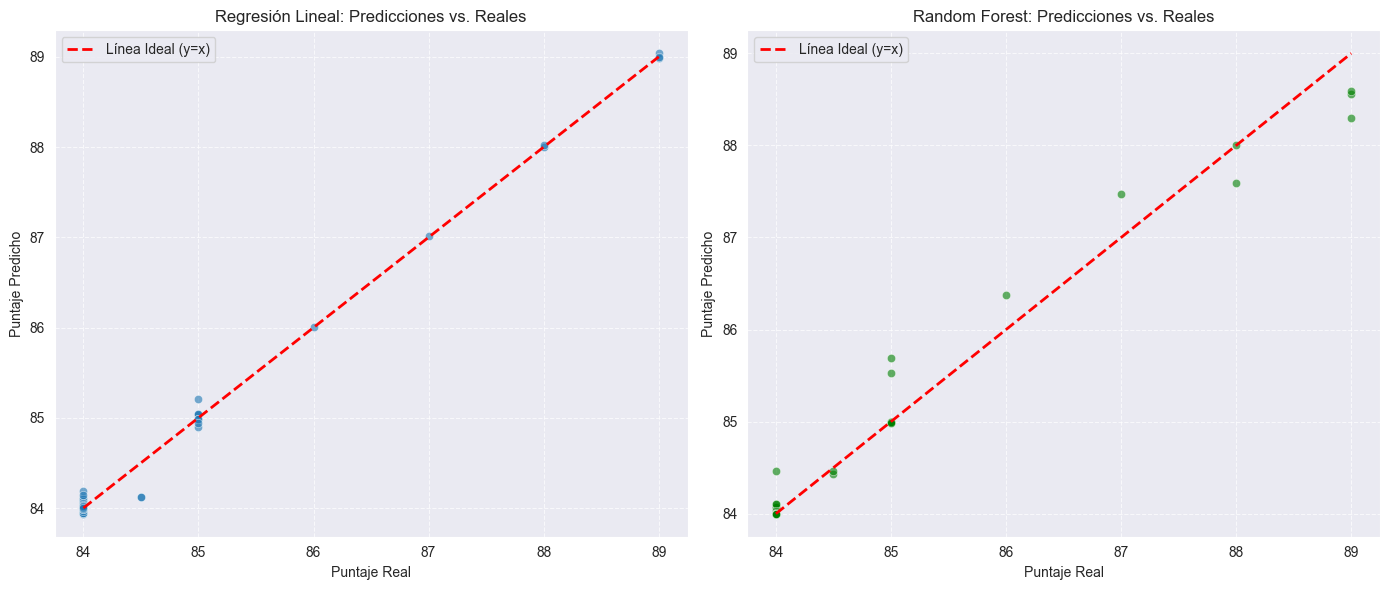

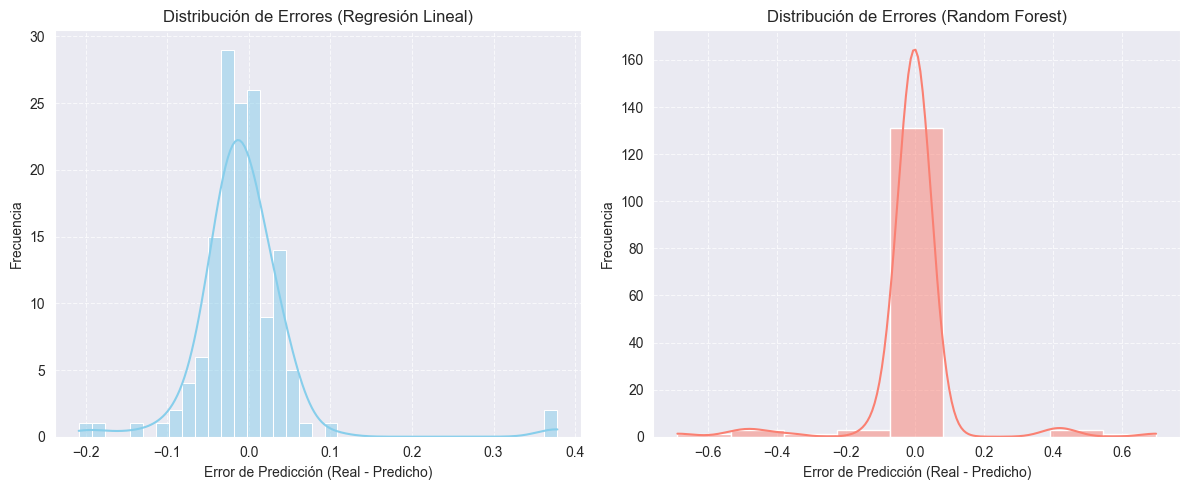


--- Fin de la Comparación ---


In [254]:
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Comparación de Resultados entre Modelos ---")

# Diccionario para almacenar las métricas de cada modelo
results = {
    'Modelo': [],
    'MAE': [],
    'MSE': [],
    'RMSE': [],
    'R2': [],
    'MAPE (%)': []
}

# --- 1. Calcular y almacenar métricas para Regresión Lineal ---
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)
epsilon = 1e-10
mape_linear = np.mean(np.abs((y_test - y_pred_linear) / (y_test + epsilon))) * 100

results['Modelo'].append('Regresión Lineal')
results['MAE'].append(mae_linear)
results['MSE'].append(mse_linear)
results['RMSE'].append(rmse_linear)
results['R2'].append(r2_linear)
results['MAPE (%)'].append(mape_linear)

# --- 2. Calcular y almacenar métricas para Random Forest ---
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / (y_test + epsilon))) * 100

results['Modelo'].append('Random Forest')
results['MAE'].append(mae_rf)
results['MSE'].append(mse_rf)
results['RMSE'].append(rmse_rf)
results['R2'].append(r2_rf)
results['MAPE (%)'].append(mape_rf)

# --- 3. Crear un DataFrame con los resultados para una fácil comparación ---
results_df = pd.DataFrame(results)
print("\nTabla Comparativa de Métricas de Rendimiento:")
print(results_df.round(4).to_string(index=False)) # .to_string(index=False) para no mostrar el índice

# --- 4. Visualización de Resultados ---

# Crear un DataFrame para la visualización (valores reales vs. predichos)
plot_df = pd.DataFrame({
    'Actual': y_test,
    'Predicción Regresión Lineal': y_pred_linear,
    'Predicción Random Forest': y_pred_rf
})

# Graficar Predicciones vs. Valores Reales
plt.figure(figsize=(14, 6))

# Subplot para Regresión Lineal
plt.subplot(1, 2, 1) # 1 fila, 2 columnas, primer gráfico
sns.scatterplot(x='Actual', y='Predicción Regresión Lineal', data=plot_df, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Línea Ideal (y=x)')
plt.title('Regresión Lineal: Predicciones vs. Reales')
plt.xlabel('Puntaje Real')
plt.ylabel('Puntaje Predicho')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Subplot para Random Forest
plt.subplot(1, 2, 2) # 1 fila, 2 columnas, segundo gráfico
sns.scatterplot(x='Actual', y='Predicción Random Forest', data=plot_df, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Línea Ideal (y=x)')
plt.title('Random Forest: Predicciones vs. Reales')
plt.xlabel('Puntaje Real')
plt.ylabel('Puntaje Predicho')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.show()

# Opcional: Graficar el error de predicción
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(y_test - y_pred_linear, kde=True, color='skyblue')
plt.title('Distribución de Errores (Regresión Lineal)')
plt.xlabel('Error de Predicción (Real - Predicho)')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
sns.histplot(y_test - y_pred_rf, kde=True, color='salmon')
plt.title('Distribución de Errores (Random Forest)')
plt.xlabel('Error de Predicción (Real - Predicho)')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("\n--- Fin de la Comparación ---")

Ambos modelos, Regresión Lineal y Random Forest, demostraron un rendimiento excepcionalmente alto en la predicción del puntaje de calidad del café, con valores de R² cercanos al 99.53% y 97.98% respectivamente, y errores porcentuales (MAPE) inferiores al 0.05% para ambos. Si bien la Regresión Lineal mostró una ventaja aparente y significativa con un MSE y RMSE considerablemente menores (0.0039 y 0.0622 vs. 0.0168 y 0.1297 para Random Forest), indicando una mayor precisión y menor penalización por errores grandes. Esto se puede explicar por la mala condición del dataset y  en espacial porque ya habíamos demostrado que la columna de PUNTAJE_# a duras penas tenía varianzaa, lo que favorece un comportamiento libeal. Es fundamental reconocer que esta tarea de predicción fue excepcionalmente desafiante. Esto se debe a que la base de datos no contiene puntajes por debajo del umbral de no aceptación, lo que limita la variabilidad de la variable objetivo y podría sesgar la percepción del rendimiento perfecto del modelo, ya que solo aprendió de un rango muy restringido de puntajes altos.